### CSE 5320 Neural Networks Project 2
#### Report (with Code)
Josias Moukpe\
11/18/2022

#### Introduction
Object detection is an advanced form of image classification where a neural network predicts objects in an image and points them out in bounding boxes. Object detection thus refers to the detection and localization of objects in an image that belongs to a predefined set of classes. Tasks like detection, recognition, or localization find widespread applicability in real-world scenarios such as autonomous driving, robotics, product quality assurance, etc., making object detection (also referred to as object recognition) a very important subdomain of Computer Vision. [2] We call Real-Time object detection when the objects in images can be recognized in mere milliseconds allowing for in-time reactions based on the detection. Our project will aim to build a real-time object detector to find and track objects of defined classes in images or video feeds.

#### Problem
This objective combines object classificationn and localization (bounding box regression task). To process images and capture the features, we will leverage convolutional neural networks and capture local pixel structures. We will comment on how our model performs in real-time object detection. To train our model, we will use the MS COCO dataset [1]. This dataset contains more than 200,000 labeled color images of 1.5 million object instances and 80 object categories. Each image is 640 x 480 pixels and includes various forms of annotations such as key points, captions, segmentations, and bounding boxes (which interest us). The model will take an image or batch of images and outputs the classes and bounding boxes of all objects detected in that image.

#### Methodology
To prepare the data, we .

#### Benchmarking
To measure training performance, we 

#### Conclusion
Overall, 


References\
[1] https://cocodataset.org/#home \
[2] https://arxiv.org/abs/1804.02767 \
[3] https://arxiv.org/abs/1506.02640 \
[4] https://arxiv.org/abs/2207.02696 \
[5] https://arxiv.org/abs/1904.04620 \
[6] https://www.v7labs.com/blog/yolo-object-detection \
[7] https://github.com/xuannianz/keras-GaussianYOLOv3 \
[8] https://www.kaggle.com/code/aruchomu/yolo-v3-object-detection-in-tensorflow

Obtaining the COCO 2017 Dataset

In [1]:
# list the contents of the current 
# directory on my remote server
!ls
!ls "/notebooks/data/"

README.md  config  data  models
annotations  coco.names  test2017  train2017  val2017


In [6]:
# navigate to the data directory
# and list the contents
# %cd "/notebooks/data"
# !ls

# # downloading coco (2017) dataset
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/image_info_test2017.zip

# # unzip the files
# !unzip train2017.zip
# !unzip val2017.zip
# !unzip test2017.zip
# !unzip annotations_trainval2017.zip
# !unzip stuff_annotations_trainval2017.zip
# !unzip image_info_test2017.zip

# # remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip

# navigate out of the data directory
# and list the contents
# %cd "/notebooks"
# !ls


In [11]:
# create a config directory
# %cd "/notebooks"
# %mkdir config
# %cd config
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
# %cd ..

/notebooks
/notebooks/config
--2022-11-20 15:38:03--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0.01s   

2022-11-20 15:38:03 (675 KB/s) - ‘yolov3.cfg’ saved [8342/8342]

/notebooks


In [10]:
!pwd

/root


In [12]:
# create a models directory
# %cd "/notebooks"
# %mkdir models
# %cd models
# !wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
# %cd ..

/notebooks
mkdir: cannot create directory ‘models’: File exists
/notebooks/models
--2022-11-20 15:54:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  5.13MB/s    in 44s     

2022-11-20 15:54:54 (5.41 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

/notebooks


In [2]:
# install gluoncv to help with the dataset
%pip install gluoncv
%pip install mxnet
%pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 38.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# imports 
import cv2
import glob
import io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from random import randint, choice
import tensorflow as tf
from tensorflow.keras import backend as K
from keras import engine as KE
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.preprocessing.image
# read coco dataset
from gluoncv import data, utils
# print the version of tensorflow
print(tf.__version__)


2.9.1


/usr/local/lib/python3.9/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.12.0+cu116` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [6]:
# check if gpu is available and what type
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())


Num GPUs Available:  1
/device:GPU:0


### Loading the dataset
MS COCO 2017 is our dataset. Link to loaded dataset in our remote development compute node
https://console.paperspace.com/erud1t3/notebook/r92lxtvwhlbkhcy

In [7]:
!pwd

/notebooks


In [8]:
# loading the coco dataset
train_ds = data.COCODetection('./data/', splits=['instances_train2017'])
val_ds = data.COCODetection('./data/', splits=['instances_val2017'])


/usr/local/lib/python3.9/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting pycocotools

Downloading pycocotools-2.0.6.tar.gz (24 kB)

Installing build dependencies: started

Installing build dependencies: finished with status 'done'

Getting requirements to build wheel: started

Getting requirements to build wheel: finished with status 'done'

Preparing metadata (pyproject.toml): started

Preparing metadata (pyproject.toml): finished with status 'done'

Requirement already satisfied: matplotlib>=2.1.0 in /usr/local/lib/python3.9/dist-packages (from pycocotools) (3.5.2)

Requirement already satisfied: numpy in /usr/local/lib/python3.9/dist-packages (from pycocotools) (1.23.1)

Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (2.8.2)

Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (0.11.0)

Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (1.4.3)

Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (9.2.0)

Requirement already satisfied: pyparsing>=2.2.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (3.0.9)

Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (4.34.4)

Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (21.3)

Requirement already satisfied: six>=1.5 in /usr/lib/python3/dist-packages (from python-dateutil>=2.7->matplotlib>=2.1.0->pycocotools) (1.14.0)

Building wheels for collected packages: pycocotools

Building wheel for pycocotools (pyproject.toml): started

Building wheel for pycocotools (pyproject.toml): finished with status 'done'

Created wheel for pycocotools: filename=pycocotools-2.0.6-cp39-cp39-linux_x86_64.whl size=400229 sha256=7aa18bbd29a6bef54e95c188b9020175d5f314683f7868ceec02180a3dfb0985

Stored in directory: /root/.cache/pip/wheels/2f/58/25/e78f1f766e904a9071266661d20d0bc6644df86bcd160aba11

Successfully built pycocotools

Installing collected packages: pycocotools

Successfully installed pycocotools-2.0.6

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


loading annotations into memory...
Done (t=13.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [9]:

# print the length of the dataset
print('Length of training dataset:', len(train_ds))
print('Length of validation dataset:', len(val_ds))

Length of training dataset: 117266
Length of validation dataset: 4952


In [10]:
# plot a random image from coco dataset
def plot_image(image, label):
    '''
    Plots an image and its bounding boxes
    '''
    print('Image size (height, width, RGB):', image.shape)
    # print('Label:', label)
    print('shape of label:', label.shape)
    # plot the image
    bounding_boxes = label[:, :4]
    class_ids = label[:, 4:5]
    print('number of objects in the image:', bounding_boxes.shape[0])
    print('bounding boxes (# boxes, min x, min y, max x, max y): \n', bounding_boxes)
    print('class ids (# boxes, class id): \n', class_ids)
    ax = utils.viz.plot_bbox(
        image.asnumpy(), 
        bounding_boxes, 
        scores=None, 
        labels=class_ids, 
        class_names=train_ds.classes
    )
    plt.show()
  

Image size (height, width, RGB): (333, 500, 3)
shape of label: (6, 5)
number of objects in the image: 6
bounding boxes (# boxes, min x, min y, max x, max y): 
 [[320.28  14.22 463.7  323.77]
 [277.3    9.03 431.53 312.34]
 [141.43  10.53 244.45 311.1 ]
 [ 75.65  61.9  155.39 139.06]
 [307.08 200.83 311.94 211.16]
 [425.49 106.04 452.76 138.23]]
class ids (# boxes, class id): 
 [[ 0.]
 [ 0.]
 [ 0.]
 [34.]
 [34.]
 [34.]]


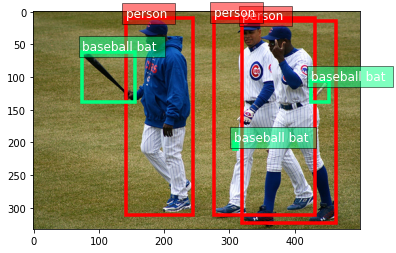

In [13]:
# pick a random image from validation dataset
image, label = val_ds[randint(0, len(val_ds))]
plot_image(image, label)


### Working the model
We will be building Gaussian YoloV3 model

In [14]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

In [15]:
num_classes = 80
classes = load_classes("./data/coco.names")
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [35]:
# hyprameters
BATCH_SIZE = 1
CONFIDENCE = 0.5
NMS_CONF = 0.4


### Video Demo of Gaussian Yolov3 (YoloG) in Real Time